# Import

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
import umap

import copy

# bs = 100
# # MNIST Dataset
# train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
# test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# # Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# VAE/Agent class

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.encoder_net = nn.Sequential( nn.Linear(x_dim, h_dim1),
                                 nn.LeakyReLU(),
                                 nn.Linear(h_dim1, h_dim2),
                                 nn.LeakyReLU())
#         self.fc1 = nn.Linear(x_dim, h_dim1)
#         self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        
        self.encoder_params = list(self.encoder_net.parameters()) + \
            list(self.fc31.parameters()) + \
            list(self.fc32.parameters())
        # decoder part
        
        self.decoder_net = nn.Sequential( nn.Linear(z_dim, h_dim2),
                                     nn.LeakyReLU(),
                                     nn.Linear(h_dim2, h_dim1),
                                     nn.LeakyReLU(), 
                                     nn.Linear(h_dim1, x_dim), 
                                     nn.Tanh())
        
        self.decoder_params = list(self.decoder_net.parameters())

            
#         self.fc4 = nn.Linear(z_dim, h_dim2)
#         self.fc5 = nn.Linear(h_dim2, h_dim1)
#         self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
#         h = F.relu(self.fc1(x))
#         h = F.relu(self.fc2(h))
        
        h = self.encoder_net(x)
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
#         h = F.relu(self.fc4(z))
#         h = F.relu(self.fc5(h))
        return self.decoder_net(z) # torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
#         mu, log_var = self.encoder(x.view(-1, 25))
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# # build model
# vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
# if torch.cuda.is_available():
#     vae.cuda()

In [117]:
class agent():
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        self.vae = VAE(x_dim=x_dim, h_dim1=h_dim1, h_dim2=h_dim2, z_dim=z_dim)
        if torch.cuda.is_available():
            self.device = "cuda"
            self.vae.cuda()
        else:
            self.device = "cpu"
        self.z_dim = z_dim
        
        # optimizers
        self.optimizer_speaker = optim.Adam(self.vae.decoder_params)  # speaker is trying to make unique signals which only uses the deocder
        self.optimizer_listen = optim.Adam(self.vae.parameters())
        
    
    def generate_signal(self):
        mu = torch.normal(0., 1., size=(self.z_dim,)).to(self.device)
        log_var = torch.normal(0., 1., size=(self.z_dim,)).to(self.device)
        
        z = self.vae.sampling(mu, log_var)
        signal = self.vae.decoder(z)
        return signal
    

# return reconstruction error + KL divergence losses
def listener_loss_function(recon_x, x, mu, log_var):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    MSE = F.mse_loss(recon_x, x, reduction='sum')  # loss that tries to copy/reconstruct speaker's message
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + KLD 

def speaker_loss_function(recon_x, x):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
#     MSE = (2 - torch.abs(F.mse_loss(recon_x, x.view(-1, 25), reduction='sum')) )  # loss that tries to keep speaker's message unique
    MSE = torch.sum(torch.pow(2 - torch.abs(recon_x - x), 2))
#     KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE 

# populate agents
numAgents = 100
res = 5

agents = []
for i in range(0, numAgents):
    agents.append(agent(x_dim=res*res, h_dim1 = 200, h_dim2=200, z_dim=5))

In [372]:
agents2 = copy.deepcopy(agents)

# Optimizer/Training

In [118]:
numMsgs = 10

def train(epoch):
    
    a = 1.75
    
    for agent in agents:
        agent.vae.train()
        agent.optimizer_listen.zero_grad()
    
    train_speaker_loss = 0
    train_listener_loss = 0
    
    event_count = 0
    
    agent_order = np.random.permutation(np.arange(0, len(agents)))
    for i in agent_order:
        listener = agents[i]
        
#         neighbours = [(i - 1) % len(agents), (i + 1) % len(agents)]  # 1D periodic chain
        
        if not int(np.sqrt(len(agents))**2 == len(agents):
            raiseValueErroreError('len(agents) must be a perfect square!')
        grid_res = int(np.sqrt(len(agents)))
        neighbours = [(i - 1) % grid_res, (i + 1) % grid_res, (i + grid_res) % len(agents), (i - grid_res) % len(agents)]  # 2D lattice
        # neighbours = np.random.permutation(agent_order[agent_order != i])  # fully connected network
        
        for n in neighbours:
            speaker = agents[n]
            
            # data = [speaker.generate_signal() + 0.5*torch.randn(25).cuda() for i in range(numMsgs)]
            data = [speaker.generate_signal() for i in range(numMsgs)]
            t_data = data[0].view(1, -1)
            for item in data[1:]:
                t_data=torch.cat((t_data,item.view(1, -1)),dim=0)
            data = t_data
            
            # listen/reconstruct spoken signals
            recon_batch, mu, log_var = listener.vae(data.detach())
            
            # calculate loss
            listener_loss = a*listener_loss_function(recon_batch, data.detach(), mu, log_var)
            speaker_loss = (2-a)*speaker_loss_function(recon_batch.detach(), data)
            
            # calculate gradients
            listener_loss.backward()
            speaker_loss.backward()
            
            train_speaker_loss += speaker_loss.item()
            train_listener_loss += listener_loss.item()
            
            '''
            print(event_count)
            params.append(list(speaker.vae.parameters()))
            params_current = [p for p in params[-1]]
            if event_count > 0:
                params_old = [p for p in params[-2]]
                print(params_current[0] - params_old[0])
            
            
            dnet = list(speaker.vae.decoder_net.parameters())
            print('Speak grad: ', [torch.sum(torch.abs(d.grad.detach().cpu())) for d in dnet])
            '''
    
            event_count += 1
    
    # push gradients only at the end of all speaking/listening events
    for agent in agents:
        # agent.optimizer_speaker.step()
        agent.optimizer_listen.step()
        
    train_speaker_loss = train_speaker_loss / event_count / numMsgs
    train_listener_loss = train_listener_loss / event_count / numMsgs
    
    print(f'====> Epoch: {epoch} Speak/Listen loss: {train_speaker_loss:.4f}/{train_listener_loss:.4f} ')
    
    return train_speaker_loss, train_listener_loss

SyntaxError: invalid syntax (<ipython-input-118-76a5265c6bea>, line 22)

In [358]:
reducer = umap.UMAP()

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
        grad_fn=<SubBackward0>),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Generating UMAP embeddings...


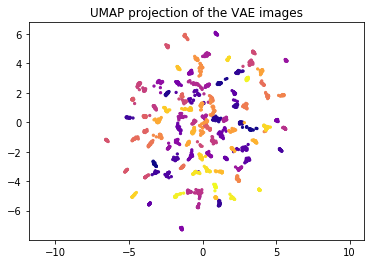

====> Epoch: 1 Speak/Listen loss: 42.7676/1.4726 
====> Epoch: 2 Speak/Listen loss: 40.1403/2.6930 
====> Epoch: 3 Speak/Listen loss: 37.1640/4.5200 
====> Epoch: 4 Speak/Listen loss: 34.2224/6.8907 
====> Epoch: 5 Speak/Listen loss: 31.6866/9.4192 
====> Epoch: 6 Speak/Listen loss: 29.2261/12.4325 
====> Epoch: 7 Speak/Listen loss: 27.3994/14.8837 
====> Epoch: 8 Speak/Listen loss: 26.1257/16.7402 
====> Epoch: 9 Speak/Listen loss: 25.1778/18.2742 
====> Epoch: 10 Speak/Listen loss: 24.7243/19.0055 
====> Epoch: 11 Speak/Listen loss: 24.4816/19.3316 
====> Epoch: 12 Speak/Listen loss: 24.5873/19.2903 
====> Epoch: 13 Speak/Listen loss: 24.8566/18.9246 
====> Epoch: 14 Speak/Listen loss: 25.3825/18.0902 
====> Epoch: 15 Speak/Listen loss: 25.7358/17.6780 
====> Epoch: 16 Speak/Listen loss: 26.0243/17.5018 
====> Epoch: 17 Speak/Listen loss: 26.2063/17.4906 
====> Epoch: 18 Speak/Listen loss: 26.4019/17.4995 
====> Epoch: 19 Speak/Listen loss: 26.5990/17.4831 
====> Epoch: 20 Speak/List

In [ ]:
loss = []
numExamples = 10
for epoch in range(1, 3000):
    
    if not epoch % 100 or epoch == 1:
        
        # plot examples
        '''
        fig, axs = plt.subplots(len(agents), numExamples, figsize=(numExamples, len(agents)))

        for i, ax in enumerate(axs.flatten()):
            a_i = int(i/numExamples)
            ax.imshow(agents[a_i].generate_signal().cpu().detach().reshape(res, res), vmin=-1, vmax=1)
            ax.set_axis_off()
            
        plt.show()
        '''
        
        # plot umap embeddings
        print('Generating UMAP embeddings...')
        numImgs = 25
        imgs = [a.generate_signal().cpu().detach().numpy() for a in agents for i in range(0, numImgs)]
        labels = [i for i, a in enumerate(agents) for j in range(0, numImgs)]
        embedding = reducer.fit_transform(imgs)
        plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='plasma', s=5)
        plt.gca().set_aspect('equal', 'datalim')
        plt.title('UMAP projection of the VAE images', fontsize=12)
        
        plt.show()
        
    loss.append(train(epoch))
        
#     test()

s_loss = [l[0] for l in loss]
l_loss = [l[1] for l in loss]

plt.plot(s_loss, label='speaker')
plt.plot(l_loss, label='listener')
plt.legend()

# Visualize

### Helper function

In [105]:
def ax_imshow_simple(ax):
    # make xaxis invisibel
    ax.xaxis.set_visible(False)
    # make spines (the box) invisible
    plt.setp(ax.spines.values(), visible=False)
    # remove ticks and labels for the left axis
    ax.tick_params(left=False, labelleft=False)
    #remove background patch (only needed for non-white background)
    ax.patch.set_visible(False)

## Generate images for each agent

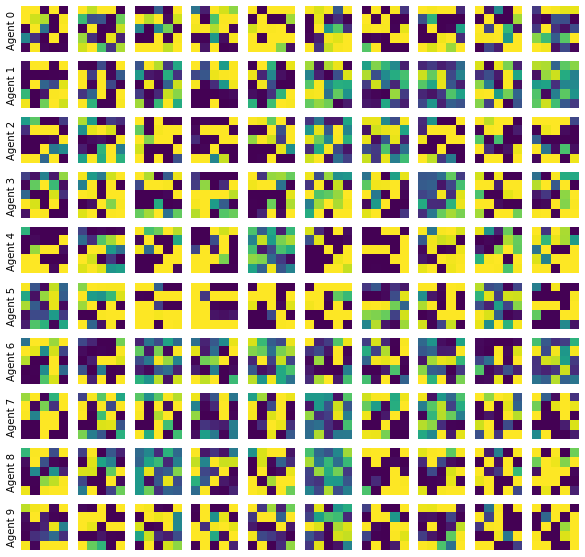

In [106]:
numExamples = 10

fig, axs = plt.subplots(len(agents), numExamples, figsize=(numExamples, len(agents)))

for i, ax in enumerate(axs.flatten()):
    a_i = int(i/numExamples)
    ax.imshow(agents[a_i].generate_signal().cpu().detach().reshape(res, res), vmin=-1, vmax=1)
    # ax.set_axis_off()
    ax_imshow_simple(ax)
    if not i % len(agents):
        ax.set_ylabel(f'Agent {a_i}')

plt.show()

## Generate images for one agents

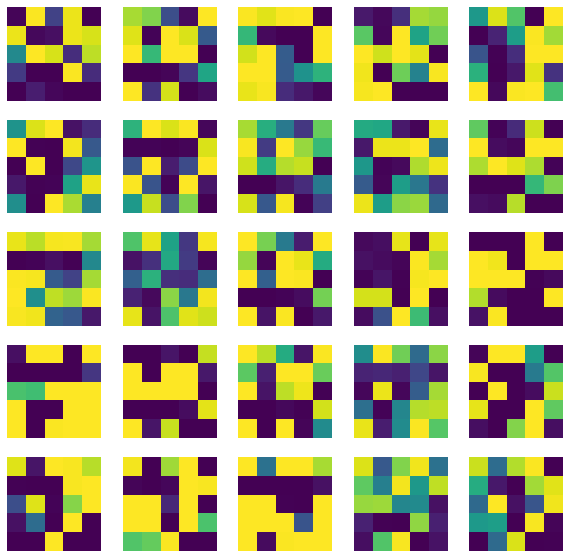

In [107]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

i = 1
for ax in axs.flatten():
    ax.imshow(agents[i].generate_signal().cpu().detach().reshape(res, res), vmin=-1, vmax=1)
    ax.set_axis_off()

## Encode an image (or noise)

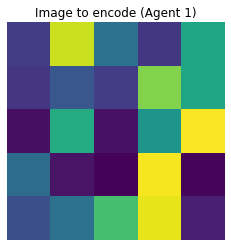

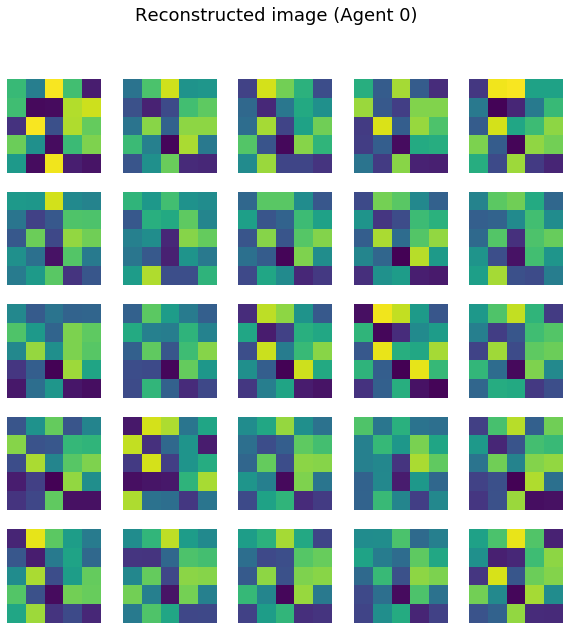

In [116]:
i = 1  # speaker
j = 0  # listener

# image to reconstruct
signal_i = agents[i].generate_signal()
img_i = signal_i.cpu().detach().reshape(res, res)

# random image
# signal_i = torch.randn(25).cuda()
# img_i = signal_i.cpu().detach().reshape(5,5)

fig, ax = plt.subplots()
ax.imshow(img_i, vmin=-1, vmax=1)
ax_imshow_simple(ax)
ax.set_title(f'Image to encode (Agent {i})')
# plt.imshow(img_i)


fig, axs = plt.subplots(5, 5, figsize=(10, 10))
# reconstruction
for ax in axs.flatten():
    ax.imshow(agents[j].vae(signal_i)[0].cpu().detach().reshape(res, res), vmin=-1, vmax=1)
    ax.set_axis_off()
fig.suptitle(f'Reconstructed image (Agent {j})', fontsize=18)
plt.show()
    
    

# UMAP

In [25]:
import umap

In [26]:
reducer = umap.UMAP()

In [57]:
numImgs = 2000
imgs = [a.generate_signal().cpu().detach().numpy() for a in agents for i in range(0, numImgs)]
labels = [i for i, a in enumerate(agents) for j in range(0, numImgs)]

In [58]:
embedding = reducer.fit_transform(imgs)

d:\anaconda\envs\population_vae\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\anaconda\envs\population_vae\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
d:\anaconda\envs\population_vae\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\anaconda\envs\population_vae\lib\site-packages\umap\r

Text(0.5, 1.0, 'UMAP projection of the VAE images')

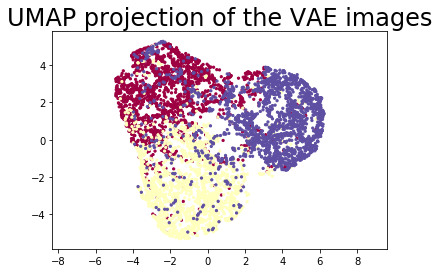

In [59]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the VAE images', fontsize=24)

# Debug

In [222]:
data = [agents[0].generate_signal() for i in range(numMsgs)]
t_data = data[0].view(1, -1)
for item in data[1:]:
    t_data=torch.cat((t_data,item.view(1, -1)),dim=0)
    
t_data

tensor([[0.4844, 0.5276, 0.5003, 0.5722, 0.4717, 0.5699, 0.5534, 0.4541, 0.5044,
         0.5125, 0.4875, 0.4442, 0.5457, 0.5306, 0.5260, 0.5084, 0.4900, 0.5720,
         0.4873, 0.4732, 0.4692, 0.4590, 0.5524, 0.5184, 0.5062],
        [0.4991, 0.5503, 0.4910, 0.5422, 0.4915, 0.5699, 0.5457, 0.4782, 0.4902,
         0.4741, 0.4732, 0.4520, 0.5871, 0.5808, 0.5663, 0.5106, 0.4256, 0.5946,
         0.4597, 0.4905, 0.4740, 0.4573, 0.5626, 0.4989, 0.5314],
        [0.4902, 0.5437, 0.5393, 0.5342, 0.4384, 0.5387, 0.5885, 0.5264, 0.5231,
         0.4640, 0.5521, 0.4300, 0.5718, 0.5262, 0.4920, 0.4693, 0.4806, 0.5740,
         0.4946, 0.4066, 0.4744, 0.4936, 0.5163, 0.4434, 0.5232],
        [0.4958, 0.5399, 0.5282, 0.5330, 0.4448, 0.5562, 0.5688, 0.5212, 0.5050,
         0.4710, 0.5216, 0.4466, 0.5572, 0.5224, 0.5178, 0.5204, 0.4718, 0.5811,
         0.4813, 0.4289, 0.4834, 0.5101, 0.5117, 0.4910, 0.5282],
        [0.4665, 0.5225, 0.4955, 0.5657, 0.4623, 0.5670, 0.5358, 0.4308, 0.4952,
       